In [55]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 1

%aimport b6_epilepsies 
import b6_epilepsies as b6 #.py file in the same dir as this .ipynb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# from scipy.stats import mannwhitneyu

# Define the custom color palette and genotype order
new_colors_order = sns.color_palette(palette='Set2', n_colors=3)
new_colors_order[0], new_colors_order[1], new_colors_order[2] = new_colors_order[1], new_colors_order[0], new_colors_order[2]
color_map = dict(zip(['wt', 'het', 'hom'], new_colors_order))


# Define input variables
date   = "241107"
box1   = "16"
box2   = "17"
exp    = "PNPO_PTZ"
export = False
    
pnpo_ptz_obj_raw = b6.RawData(date, box1, box2, exp, export) #.prepped_data attribute to access df
# pnpo_ptz_obj_mid = b6.MiddurData(date, box1, box2, exp, export) #.prepped_data attribute to access df

df_raw = pnpo_ptz_obj_raw.df

# df_raw.to_csv('241107_16_17_PNPO_PTZ_TIDIED_DF.csv')
# df_mid = pnpo_ptz_obj_mid.prepped_data


# date   = "241030"
# box1   = "16"
# box2   = "17"
# exp    = "WT_PTZ"
# export = False
    
# wt_ptz_obj_raw = b6.RawData(date, box1, box2, exp, export) #.prepped_data attribute to access df
# # wt_ptz_obj_mid.quick_plot_per_fish()
# df_raw = wt_ptz_obj_raw.df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start of experiment: 2024-11-07 16:25:58
Preparing 241107_16_17_PNPO_PTZ/241107_16_17_PNPO_PTZ_raw_df.csv.
We have a condition!
Done


In [3]:
# Set the reference time (e.g., the earliest timestamp)
# Calculate elapsed time in seconds (or use .total_seconds() for float)
reference_time = df_raw['fullts'].min()
df_raw['elapsed_time'] = (df_raw['fullts'] - reference_time).dt.total_seconds()/60

# Trim rows where elapsed time is less than 12 minutes
filtered_df = df[df['elapsed_time'] >= 12]

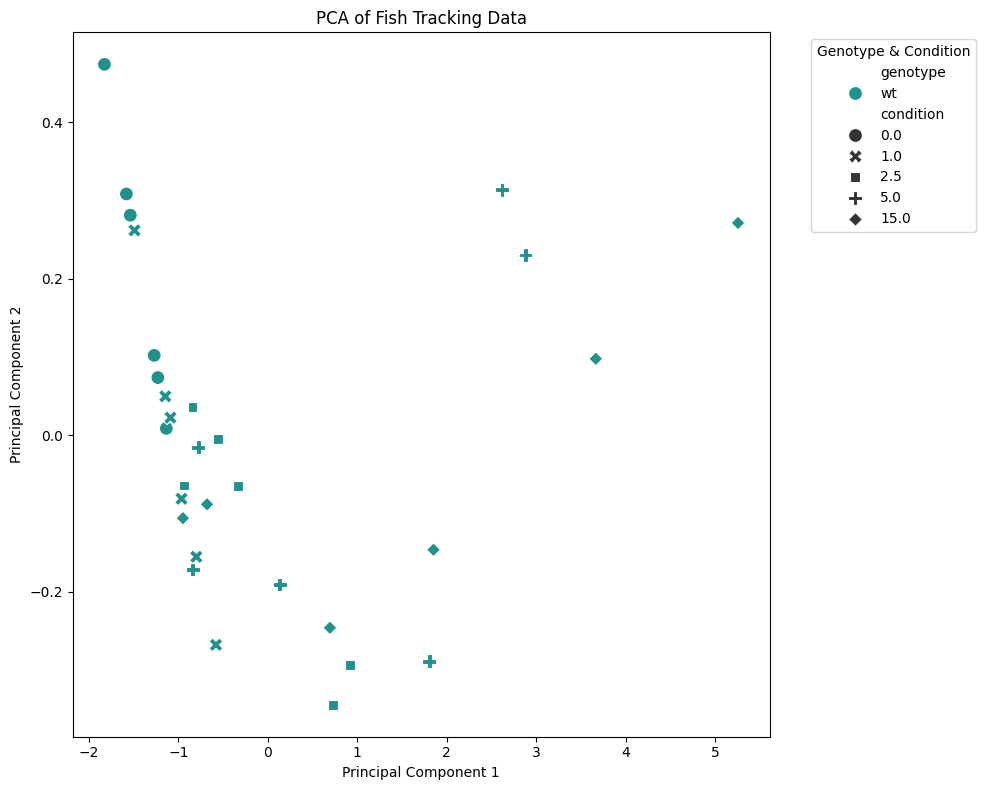

Explained variance ratio: [0.9856795 0.0143205]


In [49]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = df_raw

# Step 1: Data Cleaning
# Remove rows where `data1` is NaN or wells are empty
df_cleaned = df.dropna(subset=['data1']).copy()

# Step 2: Summarisation
# Group by fish (location, genotype, condition) and summarise tracking data
grouped = df_cleaned.groupby(['location', 'genotype', 'condition']).agg(
    mean_activity=('data1', 'mean'),
    variance_activity=('data1', 'var'),
    total_activity=('data1', 'sum')
).reset_index()

# Step 3: Standardisation
# Standardise summarised tracking data
scaler = StandardScaler()
activity_data = grouped[['mean_activity', 'variance_activity', 'total_activity']]
scaled_data = scaler.fit_transform(activity_data)

# Step 4: PCA
# Perform PCA on the scaled data
pca = PCA(n_components=2)  # Reduce to 2 components for visualisation
principal_components = pca.fit_transform(scaled_data)

# Add PCA results to the DataFrame
grouped['PC1'] = principal_components[:, 0]
grouped['PC2'] = principal_components[:, 1]

# Step 5: Visualisation
# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='genotype', style='condition', 
    data=grouped, palette='viridis', s=100
)
plt.title('PCA of Fish Tracking Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Genotype & Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 6: Explained Variance
# Display the amount of variance explained by each principal component
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Feature Contributions to Principal Components:
                        PC1       PC2
mean_activity      0.579474 -0.405228
variance_activity  0.573079  0.819500
total_activity     0.579474 -0.405228


<Figure size 800x600 with 0 Axes>

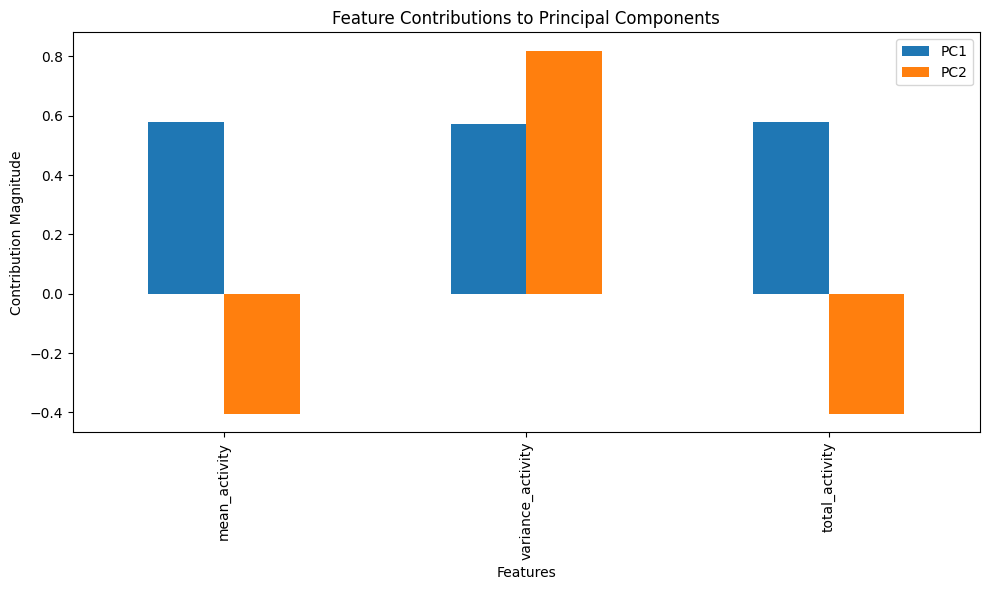

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


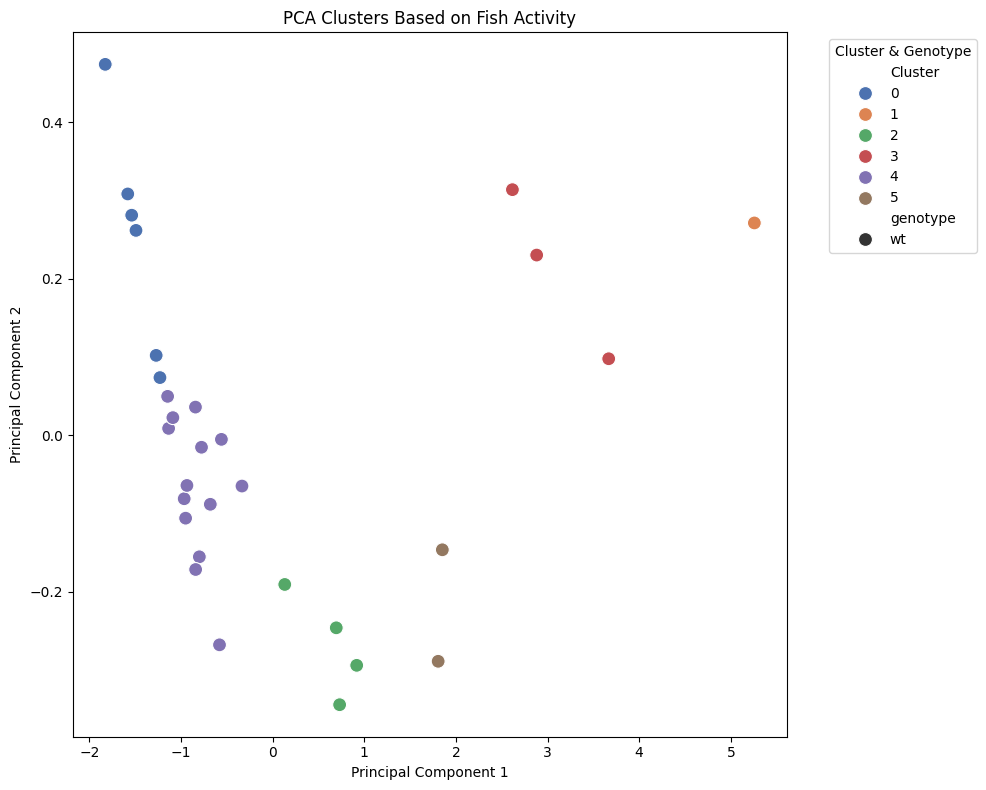

Cluster Analysis:
         mean_PC1  mean_PC2  mean_activity  variance_activity  total_activity
Cluster                                                                      
0       -1.488952  0.250175       0.865764          56.025942    32466.166667
1        5.256796  0.271301      12.161253       21822.240377   456047.000000
2        0.619122 -0.268856       5.012493        4443.540910   187968.500000
3        3.055263  0.213946       8.534089       14486.856261   320028.333333
4       -0.830295 -0.064529       2.340392         726.207491    87764.714286
5        1.829387 -0.217681       6.983427        8566.316382   261878.500000
Results saved to pca_cluster_results.csv


In [50]:
import numpy as np

# Step 1: Check Feature Contributions to PCA
# Retrieve the feature contributions (loadings) to the principal components
pca_loadings = pd.DataFrame(
    pca.components_.T, 
    index=['mean_activity', 'variance_activity', 'total_activity'], 
    columns=['PC1', 'PC2']
)

print("Feature Contributions to Principal Components:")
print(pca_loadings)

# Visualise the contributions
plt.figure(figsize=(8, 6))
pca_loadings[['PC1', 'PC2']].plot(kind='bar', figsize=(10, 6), legend=True)
plt.title("Feature Contributions to Principal Components")
plt.ylabel("Contribution Magnitude")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

# Step 2: Investigate Specific Clusters
# Add a cluster column using k-means clustering
from sklearn.cluster import KMeans

# Perform k-means clustering on the PCA results
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
grouped['Cluster'] = kmeans.fit_predict(principal_components)

# Visualise clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', style='genotype',
    data=grouped, palette='deep', s=100
)
plt.title("PCA Clusters Based on Fish Activity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster & Genotype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 3: Analyse Cluster Properties
# Group by cluster and calculate statistics for features
cluster_analysis = grouped.groupby('Cluster').agg(
    mean_PC1=('PC1', 'mean'),
    mean_PC2=('PC2', 'mean'),
    mean_activity=('mean_activity', 'mean'),
    variance_activity=('variance_activity', 'mean'),
    total_activity=('total_activity', 'mean')
)

print("Cluster Analysis:")
print(cluster_analysis)

# Step 4: Save Results
# Save the PCA and cluster results for further exploration
output_file = "pca_cluster_results.csv"
grouped.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

TEMPORAL FEATURES

/opt/homebrew/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


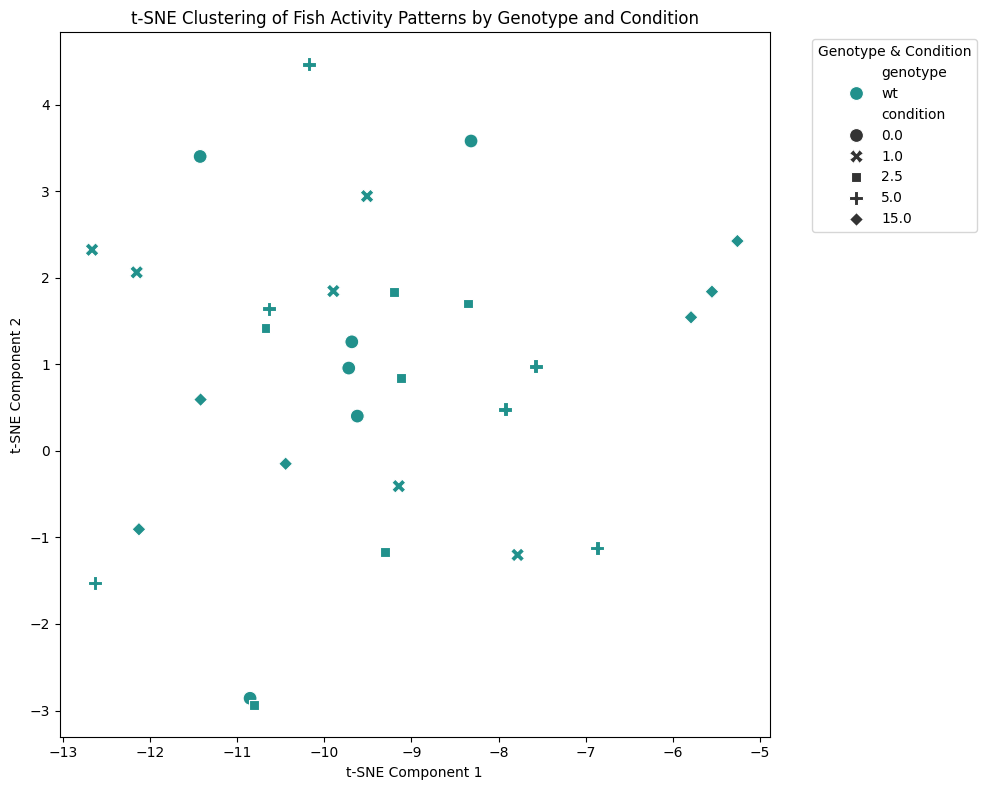

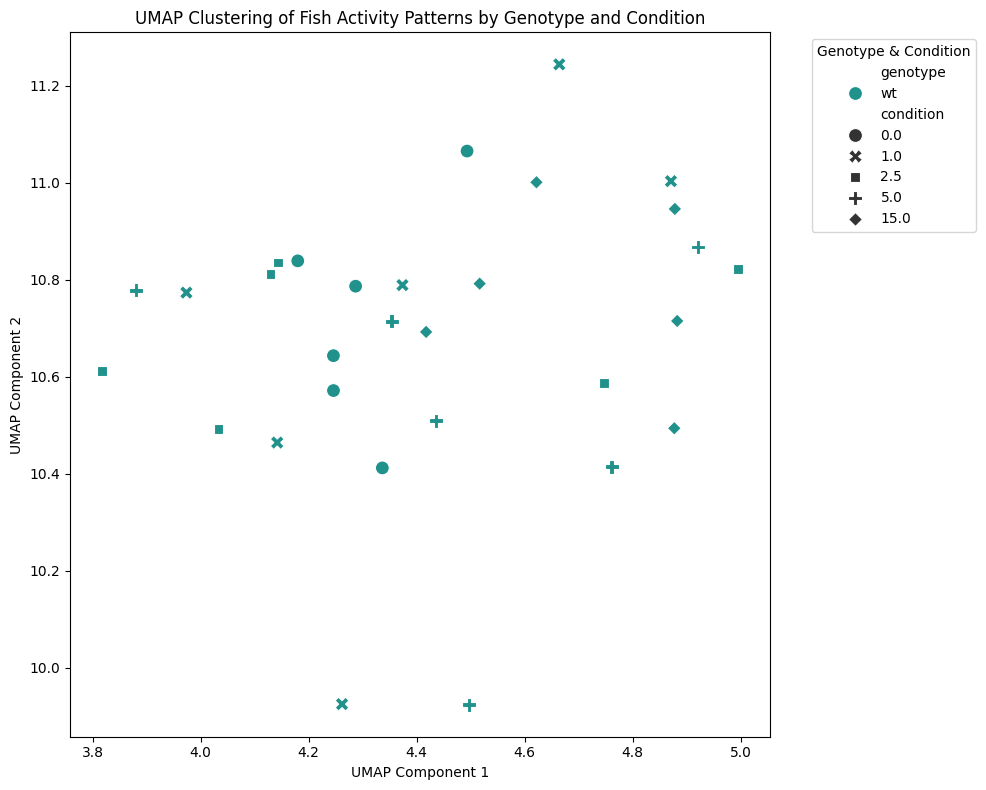

Results saved to 'temporal_features_with_tsne_umap.csv'


In [53]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = filtered_df

# Step 1: Extract Temporal Features
# Group data by fish and extract time-series features
temporal_features = []
time_bins = 66  # Divide 45 minutes into 9 five-minute chunks

for name, group in df.groupby(['location']):
    time_series = group['data1'].values
    chunks = np.array_split(time_series, time_bins)
    
    features = {
        'location': group['location'].iloc[0],
        'genotype': group['genotype'].iloc[0],
        'condition': group['condition'].iloc[0],
        'mean_activity': np.mean(time_series),
        'variance_activity': np.var(time_series),
        'peak_activity': np.max(time_series),
        'time_of_peak': np.argmax(time_series),
        'activity_bursts': np.sum(time_series > np.mean(time_series) + np.std(time_series))
    }
    
    # Add mean activity for each chunk
    for i, chunk in enumerate(chunks):
        features[f'mean_chunk_{i}'] = np.mean(chunk)
        
    temporal_features.append(features)

# Convert to a DataFrame
temporal_features_df = pd.DataFrame(temporal_features)

# Standardise the data for t-SNE/UMAP
scaler = StandardScaler()
scaled_features = scaler.fit_transform(temporal_features_df.drop(columns=['location','genotype','condition']))

# Step 2: Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(scaled_features)

# Add t-SNE results to the DataFrame
temporal_features_df['t-SNE1'] = tsne_results[:, 0]
temporal_features_df['t-SNE2'] = tsne_results[:, 1]

# Step 3: Perform UMAP
umap = UMAP(n_components=10, random_state=42)
umap_results = umap.fit_transform(scaled_features)

# Add UMAP results to the DataFrame
temporal_features_df['UMAP1'] = umap_results[:, 0]
temporal_features_df['UMAP2'] = umap_results[:, 1]

# # Step 4: Visualisation
# # t-SNE Visualisation
# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x='t-SNE1', y='t-SNE2', hue='location', 
#     data=temporal_features_df, palette='viridis', s=100
# )
# plt.title('t-SNE Clustering of Fish Activity Patterns')
# plt.tight_layout()
# plt.show()

# # UMAP Visualisation
# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     x='UMAP1', y='UMAP2', hue='location', 
#     data=temporal_features_df, palette='viridis', s=100
# )
# plt.title('UMAP Clustering of Fish Activity Patterns')
# plt.tight_layout()
# plt.show()

# t-SNE Visualisation with Genotype and Condition
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2', 
    hue='genotype', style='condition', 
    data=temporal_features_df, palette='viridis', s=100
)
plt.title('t-SNE Clustering of Fish Activity Patterns by Genotype and Condition')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Genotype & Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# UMAP Visualisation with Genotype and Condition
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    hue='genotype', style='condition', 
    data=temporal_features_df, palette='viridis', s=100
)
plt.title('UMAP Clustering of Fish Activity Patterns by Genotype and Condition')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Genotype & Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save the results
temporal_features_df.to_csv("temporal_features_with_tsne_umap.csv", index=False)
print("Results saved to 'temporal_features_with_tsne_umap.csv'")

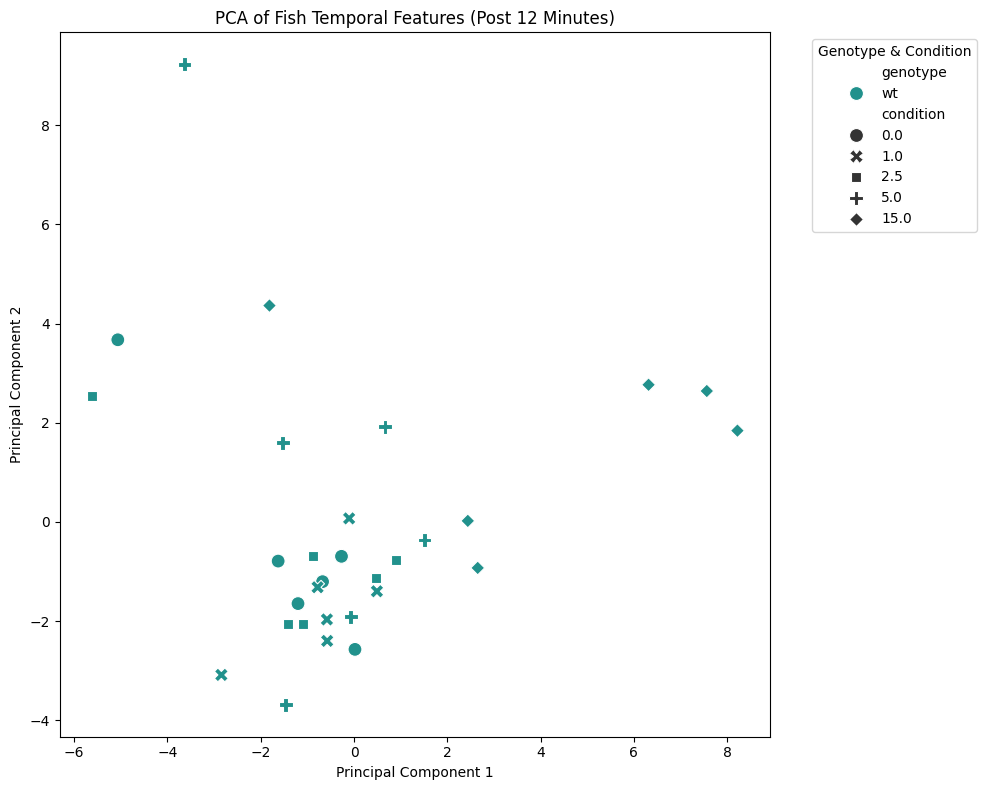

Explained variance ratio: [0.14030368 0.10718368]


In [54]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# # Assuming df_raw is your original dataset
# # Step 1: Filter out the first 12 minutes
# reference_time = df_raw['fullts'].min()
# df_raw['elapsed_time'] = (df_raw['fullts'] - reference_time).dt.total_seconds() / 60

# # Keep only rows where elapsed time is greater than or equal to 12 minutes
# filtered_df = df_raw[df_raw['elapsed_time'] >= 12]

# Step 2: Data Cleaning
# Remove rows where `data1` is NaN or wells are empty
filtered_df_cleaned = filtered_df.dropna(subset=['data1']).copy()

# Step 3: Extract Temporal Features
# Group by fish and extract time-series features
temporal_features = []
time_bins = 66  # Adjust time bins (45 - 12 = 33 mins; split into ~5-minute chunks)

for name, group in filtered_df_cleaned.groupby(['location']):
    time_series = group['data1'].values
    chunks = np.array_split(time_series, time_bins)

    features = {
        'location': group['location'].iloc[0],
        'genotype': group['genotype'].iloc[0],
        'condition': group['condition'].iloc[0]
    }

    # print(features)
    
    # Add mean activity for each chunk
    for i, chunk in enumerate(chunks):
        features[f'mean_chunk_{i}'] = np.mean(chunk)
        
    temporal_features.append(features)
    # print(temporal_features)

# Convert to a DataFrame
temporal_features_df = pd.DataFrame(temporal_features)

# Step 4: Standardisation
# Standardise temporal features
scaler = StandardScaler()
chunk_columns = [col for col in temporal_features_df.columns if 'mean_chunk_' in col]
scaled_features = scaler.fit_transform(temporal_features_df[chunk_columns])

# Step 5: PCA
# Perform PCA on the scaled temporal features
pca = PCA(n_components=2)  # Reduce to 2 components for visualisation
principal_components = pca.fit_transform(scaled_features)

# Add PCA results to the DataFrame
temporal_features_df['PC1'] = principal_components[:, 0]
temporal_features_df['PC2'] = principal_components[:, 1]

# Step 6: Visualisation
# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='genotype', style='condition', 
    data=temporal_features_df, palette='viridis', s=100
)
plt.title('PCA of Fish Temporal Features (Post 12 Minutes)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Genotype & Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 7: Explained Variance
# Display the amount of variance explained by each principal component
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

In [29]:
temporal_features_df


,location,genotype,condition,mean_activity,variance_activity,peak_activity,time_of_peak,activity_bursts,mean_chunk_0,mean_chunk_1,...,mean_chunk_56,mean_chunk_57,mean_chunk_58,mean_chunk_59,mean_chunk_60,mean_chunk_61,mean_chunk_62,mean_chunk_63,mean_chunk_64,mean_chunk_65
0,C001,HOM,0.0,2.235271,118.160105,164.0,34612,2255,0.000000,0.139224,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001340,0.000000,0.000000,0.000000,0.000000
1,C002,HET,0.0,0.255248,11.391038,105.0,15383,445,0.168675,0.713521,...,0.375335,0.221180,0.010724,0.000000,0.000000,0.000000,0.000000,0.001340,0.000000,0.000000
2,C003,HOM,0.0,0.979475,53.798210,139.0,5452,1132,0.140562,0.000000,...,0.000000,0.018767,0.000000,0.000000,0.246649,0.000000,0.000000,0.000000,0.000000,0.000000
3,C004,HOM,0.0,0.223497,9.742266,97.0,47044,391,0.018742,0.000000,...,0.000000,0.000000,0.040214,0.000000,0.000000,0.000000,1.438338,6.130027,1.336461,0.021448
4,C005,WT,0.0,0.448699,20.135995,116.0,14072,750,0.449799,0.000000,...,0.000000,0.004021,0.852547,0.436997,3.571046,1.974531,2.983914,0.416890,1.467828,0.815013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,C091,WT,10.0,1.875695,103.271872,120.0,9995,1849,0.966533,7.211513,...,5.458445,5.198391,3.321716,3.095174,1.652815,4.974531,3.095174,5.298928,3.037534,1.550938
84,C092,HET,10.0,0.527894,16.307974,82.0,361,1082,5.235609,2.779116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
85,C093,HET,10.0,1.862357,102.784254,142.0,27843,1827,2.460509,10.752343,...,0.000000,0.000000,0.000000,7.101877,6.454424,4.261394,4.573727,0.521448,7.427614,1.827078
86,C094,WT,10.0,1.236104,58.696173,119.0,32322,1617,0.026774,4.957162,...,1.872654,2.961126,2.542895,1.561662,1.167560,4.091153,1.300268,1.584450,1.793566,2.703753
